**TUTORIAL**

This Notebook guides the reader through the various steps required for the full-pandemic calibration of the spatially explicit SEIQRD model with VOCs, vaccinations, and seasonality.

**Remaining Problems and Errors**
- If `processes` is not equal to one, the `multiprocessing` unit is activated, which _sometimes_ but not always ceases functionality. It appears do hinder functionality especially when the execution is computationally heavy. Using just one core is possible, but takes approx 4 minutes per iteration. The complete-calibration MCMC runs for a little while, but than stops working altogether (without crashing)
- When executing the PSO and MCMC, the following warning often appears: "invalid value encountered in double_scalars", which I assume has to do with the fact that some values exit their boundary conditions when their initial value is perturbed at the start of the MCMC chain.
- Another warning often appears, which has to do with the depreciated 'freq' option in pandas Timestamp objects. This is not very important, however.
- I cannot run the MCMC with only 1 core, because then the number of parameters is equal to the number of MCMC chains, and the error will apear that the chains are linearly dependent.

**Remaining Questions and Hunches for Problem Solutions**
- Make sure that the order of provinces defined in the data is the same as the order defined in e.g. `initial_state`
- The `policies_all` function that governs the social contact is defined differently for pre-pandemic times than e.g. `policies_WAVE1`. This may cause some issues, according to Tijs.
- Can the MCMC perhaps also look over various values for `warmup`, rather than only the PSO?
- It's probably best to simply use the seasonality parameter values (`amplitude` and `peak_shift`) from the national calibration, because two additional parameters make the calculations even more tedious
- 

**Research Opportunities**
- Stratify `Nc` at provincial level
- O2

# Load required packages and functions

In [8]:
# Load standard packages
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import multiprocessing as mp

# Import the spatially explicit SEIQRD model with VOCs, vaccinations, seasonality
from covid19model.models import models

# Import function to easily define the spatially explicit initial condition
from covid19model.models.utils import initial_state

# Import time-dependent parameter functions for resp. P, Nc, alpha, N_vacc, season_factor
from covid19model.models.time_dependant_parameter_fncs import make_mobility_update_function, \
                                                              make_contact_matrix_function, \
                                                              make_VOC_function, \
                                                              make_vaccination_function, \
                                                              make_seasonality_function

# Import packages containing functions to load in data used in the model and the time-dependent parameter functions
from covid19model.data import mobility, sciensano, model_parameters, VOC

# Import function associated with the PSO and MCMC
from covid19model.optimization import pso, objective_fcns
from covid19model.optimization.objective_fcns import prior_custom, prior_uniform
from covid19model.optimization.utils import perturbate_PSO, run_MCMC, assign_PSO, plot_PSO

# Load the "autoreload" extension so that package code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

################################################
### Determine geographical aggregation level ###
################################################

agg='prov'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load required data and initialise functions

## Dictionaries and DataFrames

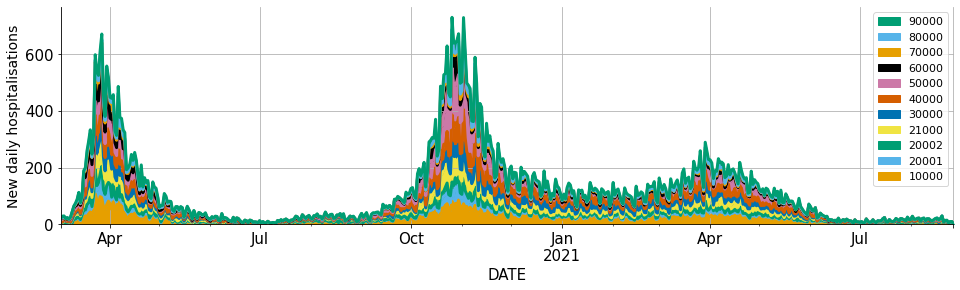

In [9]:
# Total population and contact matrices for the correct aggregation level
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices(spatial=agg)

# Google Mobility data (for social contact Nc)
df_google = mobility.get_google_mobility_data(update=False)

# Load and format mobility dataframe (for mobility place)
proximus_mobility_data, proximus_mobility_data_avg = mobility.get_proximus_mobility_data(agg, dtype='fractional', beyond_borders=False)

# Load and format national VOC data (for time-dependent VOC fraction)
df_VOC_abc = VOC.get_abc_data()

# Load and format local vaccination data, which is also under the sciensano object
public_spatial_vaccination_data = sciensano.get_public_spatial_vaccination_data(update=False,agg=agg)

# All 36 parameters associated with the full model
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg, vaccination=True,VOC=True)

# Raw local hospitalisation data used in the calibration. Moving average disabled for calibration
values = 'hospitalised_IN'
df_sciensano = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, values=values, moving_avg=False)


# SANITY CHECK: plot the full dataframe per province
fig,ax=plt.subplots(figsize=(16,4))
df_sciensano.plot(kind='area', stacked=True,ax=ax)
ax.set_ylabel('New daily hospitalisations', fontsize=14)

# Invert order of legend
handles, labels = ax.get_legend_handles_labels()
leg=ax.legend(handles[::-1], labels[::-1], loc='upper right', fontsize=11)

## Time-dependent parameter functions

c:\users\mrollier\documents\github\covid19-model\src\covid19model\models\time_dependant_parameter_fncs.py:264: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  self.df_start = pd.Timestamp(df['INCIDENCE'].ne(0).idxmax()[0], freq='D')
c:\users\mrollier\documents\github\covid19-model\src\covid19model\models\time_dependant_parameter_fncs.py:265: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  self.df_end = pd.Timestamp(df.index[-1][0], freq='D')


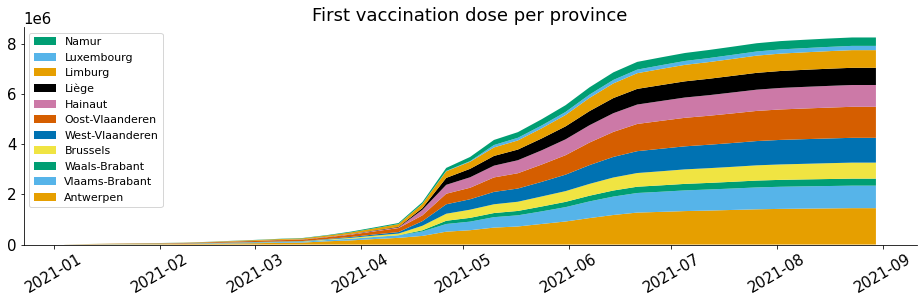

In [10]:
# Time-dependent social contact matrix over all policies, updating Nc
policy_function = make_contact_matrix_function(df_google, Nc_all).policies_all

# Time-dependent mobility function, updating P (place)
mobility_function = make_mobility_update_function(proximus_mobility_data, proximus_mobility_data_avg).mobility_wrapper_func

# Time-dependent VOC function, updating alpha
VOC_function = make_VOC_function(df_VOC_abc)

# Time-dependent (first) vaccination function, updating N_vacc
vaccination_function = make_vaccination_function(public_spatial_vaccination_data, spatial=True)

# Time-dependent seasonality function, updating season_factor
seasonality_function = make_seasonality_function()


# SANITY CHECK: plot the vaccination per province
dates_vacc = pd.date_range(start = '2021-01-01', end = '2021-09-01', freq='W-MON')
vaccs_prov=[]
for date in dates_vacc:
    vacc_prov = vaccination_function.get_sciensano_spatial_first_dose(date).sum(axis=1)
    vaccs_prov.append(vacc_prov)
vaccs_prov=np.array(vaccs_prov).cumsum(axis=0)

fig,ax = plt.subplots(figsize=(16,4))
ax.grid(False)
labels = ['Antwerpen', 'Vlaams-Brabant', 'Waals-Brabant', 'Brussels', 'West-Vlaanderen', 'Oost-Vlaanderen',\
          'Hainaut', 'Liège', 'Limburg', 'Luxembourg', 'Namur']
ax.stackplot(dates_vacc, vaccs_prov[:,0],\
             vaccs_prov[:,1],\
             vaccs_prov[:,2],\
             vaccs_prov[:,3],\
             vaccs_prov[:,4],\
             vaccs_prov[:,5],\
             vaccs_prov[:,6],\
             vaccs_prov[:,7],\
             vaccs_prov[:,8],\
             vaccs_prov[:,9],\
             vaccs_prov[:,10],\
             labels=labels)
ax.tick_params('x', labelrotation=30)
ax.set_title('First vaccination dose per province')

# Invert order of legend
handles, labels = ax.get_legend_handles_labels()
leg=ax.legend(handles[::-1], labels[::-1], loc='upper left', fontsize=11)

# Initialise model

## Pre-pandemic initial condition

The initial condition determines how many people are exposed initially, as well as their position and their age. As in the wave-1 calibration, we opt for an initial condition with the following properties:
1. A total of 3 subjects
2. All aged between 40 and 50
3. Spread equally over all provinces, scaled by the relative number of hospitalisations in each region on March 20th 2020.

Note that this implies that there will be e.g. 0.437 people in Antwerp as an initial condition. Fractional people pose no problem for our model. Other variations are possible: see the documentation of `initial_state` by executing `initial_state?`

**@TIJS**: This initial condition is _data-inspired but hard-coded_. This can be varied over in a calibration procedure.

In [11]:
# Define properties of subjects in initial condition
init_number = 3
age=40
dist='frac'

# Define the matrix of exposed subjects that will be identified with compartment E
initE = initial_state(dist='frac', agg=agg, age=age, number=init_number)

# Add the susceptible and exposed population to the initial_states dict
initial_states = {'S': initN-initE, 'E': initE}

# SANITY CHECK: the sum should be init_number
print(f'Total number of initially exposed subjects: {initE.sum()}\r')

# Verify with inhabitants of provinces to convince yourself further if needed
# inhabitants = pd.read_csv('../../data/raw/GIS/inhabitants.csv')
# inhabitants[inhabitants['NIS']==10000]['inhabitants'].values[0]

initial_states['E']

Total number of initially exposed subjects: 3.0


array([[0.        , 0.        , 0.        , 0.        , 0.43713905,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.35317637,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.0812972 ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.37983119,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.23056419,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.29853398,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.43314083,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.30386495,
        0.        , 0.        , 0.        , 0.        ],


## Addition of parameters required in the time-dependent parameters

In [12]:
# Reload params first (not necessary but often useful)
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg, vaccination=True,VOC=True)

# time-dependent social contact parameters in policies_function
params.update({'l1' : 5,
               'l2' : 5,
               'prev_schools' : 0,
               'prev_work' : .5,
               'prev_rest_lockdown' : .5,
               'prev_rest_relaxation' : .5,
               'prev_home' : .5})

# time-dependent mobility parameters in mobility_function
params.update({'default_mobility' : None})

# time-dependent vaccination parameters in vaccination_function
params.update({'initN' : initN,
               'daily_first_dose' : 60000, # copy default values from vaccination_function, which are curently not used I think
               'delay_immunity' : 14,
               'vacc_order' : [8, 7, 6, 5, 4, 3, 2, 1, 0],
               'stop_idx' : 9,
               'refusal' : [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]})

# time-dependent seasonality parameters in seasonality_function
params.update({'season_factor' : 1,
               'amplitude' : 0.1,
               'peak_shift' : 0})

## Actual initialisation of the model

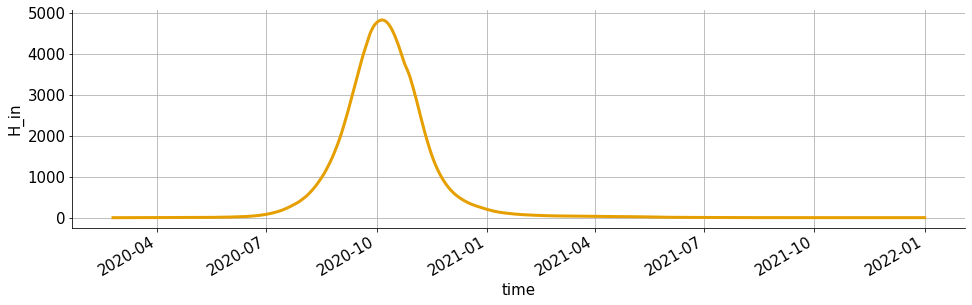

In [13]:
model = models.COVID19_SEIRD_spatial_vacc(initial_states, params, spatial=agg,
                        time_dependent_parameters={'Nc' : policy_function,
                                                   'place' : mobility_function,
                                                   'N_vacc' : vaccination_function, 
                                                   'alpha' : VOC_function,
                                                   'season_factor' : seasonality_function})

# SANITY CHECK: plot output with default values, just to see if there is *any* output
warmup = 10
start_sim = '2020-03-05' # First available data
end_sim = '2022-01-01' # Three months ahead
out = model.sim(end_sim,start_date=start_sim,warmup=warmup)

fig,ax=plt.subplots(figsize=(16,4))
graph=out['H_in'].sum(dim='Nc').sum(dim='place').plot(ax=ax)

# Calibration of the _warmup_ value

## Technical setup

@TIJS: if `processes` is not 1, this enters an infinite loop.

In [14]:
### PSO settings

# Hard-code number of cores used
# processes = 2
# Find number of available cores automatically
processes = int(os.getenv('SLURM_CPUS_ON_NODE', mp.cpu_count()))
print(f'Using {processes} cores.')

# multiplier * processes particles are used in the PSO
multiplier = 10
popsize = multiplier*processes

# Maximum number of PSO iterations
maxiter = 2

# Offset needed to deal with zeros in data in a Poisson distribution-based calibration. 1 suffices.
poisson_offset = 1

Using 12 cores.


## Data set to calibrate on

In [15]:
# Determine the boundaries between which we will calibrate the model
# Choose first date. Inspect df_sciensano.reset_index().DATE[0] if needed
start_calibration = '2020-03-02'
# Choose final date at which no interventions were felt (before first inflection point)
end_calibration = '2020-03-21'

# Identify the data. The fact that this is spatially explicit is handled automatically
data=[df_sciensano[start_calibration:end_calibration]]

# Only use the hospitalisation time series
states = ["H_in"]

# We use only one time series, so its weight is unity
weights = [1]

## PSO

In [16]:
###############################
## WARNING HEAVY CALCULATION ##
###############################

# Define the free parameters. Only warmup and the (three) transmission coefficients have an effect.
pars = ['warmup','beta_R', 'beta_U', 'beta_M']

# Define the boundaries of the parameters defined above
bounds=((0.0,60.0),(0.005,0.060), (0.005,0.060), (0.005,0.060))

# Print the conditions for user feedback
print('\n------------------------------------------')
print('PERFORMING CALIBRATION OF WARMUP and BETAs')
print('------------------------------------------\n')
print('Using data from '+start_calibration+' until '+end_calibration+'\n')
print('1) Particle swarm optimization')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')
print(f'Using {str(processes)} cores for a population of {popsize}, for maximally {maxiter} iterations.\n')

# run optimisation and safe the result in vector theta_first
theta = pso.fit_pso(model, data, pars, states, bounds, weights=weights, maxiter=maxiter, popsize=popsize, dist='poisson',
                    poisson_offset=poisson_offset, agg=agg, start_date=start_calibration, processes=processes)

# Print statement to stdout once
print(f'\nPSO RESULTS:')
print(f'------------')
print(f'warmup: {theta[0]}')
print(f'infectivities {pars[1:4]}: {theta[1:]}.')


------------------------------------------
PERFORMING CALIBRATION OF WARMUP and BETAs
------------------------------------------

Using data from 2020-03-02 until 2020-03-21

1) Particle swarm optimization
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Using 12 cores for a population of 120, for maximally 2 iterations.

No constraints given.
Best after iteration 1: [23.52152938  0.03412191  0.02595353  0.04548594] -3923.6542822386136
New best for swarm at iteration 2: [22.42261814  0.03944258  0.03863281  0.04187279] -4294.712127301053
Best after iteration 2: [22.42261814  0.03944258  0.03863281  0.04187279] -4294.712127301053
Stopping search: maximum iterations reached --> 2

PSO RESULTS:
------------
warmup: 22.422618138759056
infectivities ['beta_R', 'beta_U', 'beta_M']: [0.03944258 0.03863281 0.04187279].


Warmup value: 22 days.


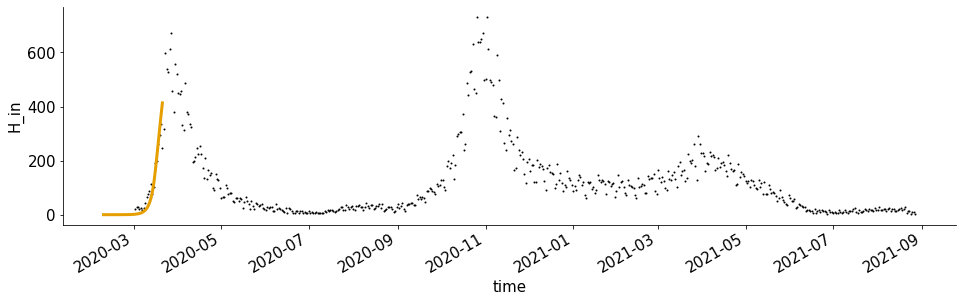

In [17]:
# Assign estimate of the transmission coefficients to the model with a utils function
warmup, pars_PSO = assign_PSO(model.parameters, pars, theta)
warmup = round(warmup)
model.parameters = pars_PSO

# Perform simulation with best-fit results
out = model.sim(end_calibration,start_date=start_calibration,warmup=warmup)

# SANITY CHECK: plot output of the calibration on the ascending part of the first wave for *national* data and simulation
fig,ax=plt.subplots(figsize=(16,4))
ax.grid(False)
graph=out['H_in'].sum(dim='Nc').sum(dim='place').plot(ax=ax)
# NOTE: the scatter plot below is very ugly. There is a better way to do this, but I can't be bothered now
graph=ax.scatter(df_sciensano.sum(axis=1).reset_index()['DATE'].values,df_sciensano.sum(axis=1).reset_index()[0].values, color='k', s=1)

# Print warmup value for user reference
message=f'Warmup value: {warmup} days.'
print('='*len(message))
print(message)
print('='*len(message))

# Note that PSO suffices for the search for warmup value.

# Calibration of the _entire_ pandemic

Note that this begins with the same procedure as for the PSO, but with more parameters.

@TIJS: this appears to malfunction when processes is not 1

## Technical setup

In [18]:
### PSO settings

# Hard-code number of cores used
processes = 1
# Find number of available cores automatically
# processes = int(os.getenv('SLURM_CPUS_ON_NODE', mp.cpu_count()))
print(f'Using {processes} cores.')

# multiplier * processes particles are used in the PSO
multiplier = 10
popsize = multiplier*processes

# Maximum number of PSO iterations
maxiter = 2


### MCMC settings

# Disable backend. Still not sure what this does
backend=None

# Maximum number of PSO iterations
max_n = 10 # 1000

# Print result every {print_n} steps. Only relevant when no progress bar can be shown (as on HPC)
print_n = 10

# Offset needed to deal with zeros in data in a Poisson distribution-based calibration. 1 suffices.
poisson_offset = 1

# Define string that identifies the output
spatial_unit = f'{agg}-full-pandemic'

# Define date at which the calibration is initiated
run_date = str(pd.to_datetime('today').date())

# Define job. This is an artefact in run_MCMC that distinguishes between a full run or a R0 run,
# which in turn defines the name of the saved .npy file
job = 'FULL'

# Choose output. In a Notebook (rather than a script), output is given regardless
progress = False

Using 1 cores.


## Data set to calibrate on

In [19]:
# Determine the boundaries between which we will calibrate the model
# Choose first date. Inspect df_sciensano.head() if needed
start_calibration = '2020-03-02'
# Choose first date. Inspect df_sciensano.tail() if needed
end_calibration = '2021-08-27'

# Identify the data. The fact that this is spatially explicit is handled automatically
data=[df_sciensano[start_calibration:end_calibration]]

# Only use the hospitalisation time series
states = ["H_in"]

# We use only one time series, so its weight is unity
weights = [1]

## PSO

In [20]:
# Define the 14 free parameters. Now there are many more that all have effects.

# transmission
pars1 = ['beta_R',     'beta_U',      'beta_M']
bounds1=((0.005,0.060),(0.005,0.060), (0.005,0.060))

# Social intertia
pars2 = ['l1',   'l2']
bounds2=((4,14), (4,14))

# Prevention parameters (effectivities)
pars3 = ['prev_schools', 'prev_work', 'prev_rest_lockdown', 'prev_rest_relaxation', 'prev_home']
bounds3=((0.15,0.95),    (0.05,0.95), (0.05,0.95),          (0.05,0.95),            (0.05,0.95))

# Effect of VOCs
pars4 = ['K_inf1',  'K_inf2']
bounds4=((1.4,1.6), (2.1,2.4))

# Effect of seasonality
pars5 = ['amplitude', 'peak_shift']
bounds5=((0,0.30),    (-31, 31))

# Join them together
pars = pars1 + pars2 + pars3 + pars4 + pars5
bounds = bounds1 + bounds2 + bounds3 + bounds4 + bounds5

In [21]:
###############################
## WARNING HEAVY CALCULATION ##
###############################

# Print the conditions for user feedback
print('\n------------------------------------------')
print('PERFORMING CALIBRATION OF WARMUP and BETAs')
print('------------------------------------------\n')
print('Using data from '+start_calibration+' until '+end_calibration+'\n')
print('1) Particle swarm optimization')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')
print(f'Using {str(processes)} cores for a population of {popsize}, for maximally {maxiter} iterations.\n')

# run optimisation and safe the result in vector theta_first. Note how now the parameter warmup=warmup was added.
theta = pso.fit_pso(model, data, pars, states, bounds, weights=weights, maxiter=maxiter, popsize=popsize, dist='poisson',
                    poisson_offset=poisson_offset, agg=agg, start_date=start_calibration, processes=processes, warmup=warmup)

# Print statement to stdout once
print(f'\nPSO RESULTS:')
print(f'------------')
print(f'infectivities {pars[0:3]}: {theta[0:3]}.')
print(f'social intertia {pars[3:5]}: {theta[3:5]}.')
print(f'prevention parameters {pars[5:10]}: {theta[5:10]}.')
print(f'VOC effects {pars[10:12]}: {theta[10:12]}.')
print(f'Seasonality {pars[12:]}: {theta[12:]}')


------------------------------------------
PERFORMING CALIBRATION OF WARMUP and BETAs
------------------------------------------

Using data from 2020-03-02 until 2021-08-27

1) Particle swarm optimization
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Using 1 cores for a population of 10, for maximally 2 iterations.

No constraints given.


c:\users\mrollier\documents\github\covid19-model\src\covid19model\optimization\objective_fcns.py:200: RuntimeWarning: invalid value encountered in log
  ll = - np.sum(ymodel+offset_value) + np.sum(np.log(ymodel+offset_value)*(ydata+offset_value))


New best for swarm at iteration 1: [ 2.38506314e-02  1.73300045e-02  9.50634153e-03  1.14252881e+01
  4.73501960e+00  7.66817536e-01  5.00000000e-02  5.00000000e-02
  2.10118349e-01  9.50000000e-01  1.40000000e+00  2.33858348e+00
  1.73889448e-01 -1.32849283e+01] -28050.372853086672
Best after iteration 1: [ 2.38506314e-02  1.73300045e-02  9.50634153e-03  1.14252881e+01
  4.73501960e+00  7.66817536e-01  5.00000000e-02  5.00000000e-02
  2.10118349e-01  9.50000000e-01  1.40000000e+00  2.33858348e+00
  1.73889448e-01 -1.32849283e+01] -28050.372853086672
New best for swarm at iteration 2: [ 2.93807143e-02  5.00000000e-03  5.00000000e-03  9.98003282e+00
  4.00000000e+00  7.64137904e-01  5.00000000e-02  5.00000000e-02
  5.00000000e-02  9.50000000e-01  1.40000000e+00  2.36403534e+00
  7.77078095e-02 -3.10000000e+01] -56608.134008811736
Best after iteration 2: [ 2.93807143e-02  5.00000000e-03  5.00000000e-03  9.98003282e+00
  4.00000000e+00  7.64137904e-01  5.00000000e-02  5.00000000e-02
  5.0

Warmup value: 22 days.


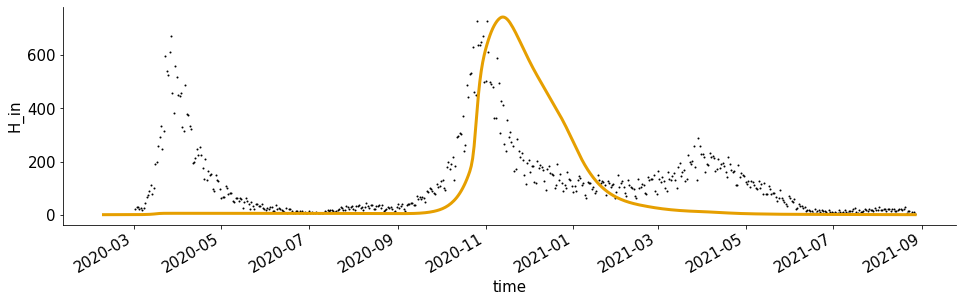

In [22]:
# Assign estimate of the transmission coefficients to the model with a utils function
pars_PSO = assign_PSO(model.parameters, pars, theta)
model.parameters = pars_PSO

# Perform simulation with best-fit results
out = model.sim(end_calibration,start_date=start_calibration,warmup=warmup)

# SANITY CHECK: plot output of the calibration on the ascending part of the first wave for *national* data and simulation
fig,ax=plt.subplots(figsize=(16,4))
ax.grid(False)
graph=out['H_in'].sum(dim='Nc').sum(dim='place').plot(ax=ax)
# NOTE: the scatter plot below is very ugly. There is a better way to do this, but I can't be bothered now
graph=ax.scatter(df_sciensano.sum(axis=1).reset_index()['DATE'].values,df_sciensano.sum(axis=1).reset_index()[0].values, color='k', s=1)

# Print warmup value for user reference
message=f'Warmup value: {warmup} days.'
print('='*len(message))
print(message)
print('='*len(message))

## MCMC

In [23]:
# overwrite number of cores used. Multiprocessing does appear to work for MCMC
processes = 2
# processes = int(os.getenv('SLURM_CPUS_ON_NODE', mp.cpu_count()))

# Redefine theta if necessary (in case of a disrupted session)
theta = [ 3.17718733e-02,  2.57464336e-02,  3.10234015e-02,  1.10146871e+01, \
          9.77557891e+00,  3.52930023e-01,  5.00000000e-02,  5.00000000e-02, \
          4.51681887e-01,  6.69250082e-01,  1.60000000e+00,  2.12120593e+00, \
          4.12019815e-02, -3.10000000e+01]
warmup = 37

# Define simple uniform priors based on the PSO bounds
log_prior_fcn = [prior_uniform, prior_uniform, prior_uniform, prior_uniform, \
                 prior_uniform, prior_uniform, prior_uniform, prior_uniform, \
                 prior_uniform, prior_uniform, prior_uniform, prior_uniform, \
                 prior_uniform, prior_uniform]
log_prior_fcn_args = bounds

# Perturbate PSO estimate by a certain maximal *fraction* in order to start every chain with a different initial condition
# Generally, the less certain we are of a value, the higher the perturbation fraction
# pars1 = ['beta_R',     'beta_U',      'beta_M']
pert1=[0.02, 0.02, 0.02]

# pars2 = ['l1',   'l2']
pert2=[0.05, 0.05]

# pars3 = ['prev_schools', 'prev_work', 'prev_rest_lockdown', 'prev_rest_relaxation', 'prev_home']
pert3=[0.2, 0.2, 0.2, 0.2, 0.2]

# pars4 = ['K_inf1',  'K_inf2']
pert4=[0.1, 0.1]

# pars5 = ['amplitude', 'peak_shift']
pert5=[0.2, 0.2]

# Join them together
pert = pert1 + pert2 + pert3 + pert4 + pert5

# Extract the number of dimensions, number of walkers, and all initial positions of all walkers
ndim, nwalkers, pos = perturbate_PSO(theta, pert, multiplier=processes, bounds=log_prior_fcn_args, verbose=False)

In [24]:
# Set up the sampler backend if needed
if backend:
    filename = f'{spatial_unit}_backend_{run_date}'
    backend = emcee.backends.HDFBackend(results_folder+filename)
    backend.reset(nwalkers, ndim)

# Labels for traceplots
labels = ['$\\beta_R$', '$\\beta_U$', '$\\beta_M$', \
          '$l_1$', '$l_2$', \
          '$\\omega_{schools}$', '$\\omega_{work}$', '$\\omega_{rest,lock}$', '$\\omega_{rest,rel}$', '$\\omega_{home}$', \
          '$K_{inf,1}$', '$K_{inf,2}$', 'amplitude', 'peak shift']

# Arguments of chosen objective function
objective_fcn = objective_fcns.log_probability
objective_fcn_args = (model, log_prior_fcn, log_prior_fcn_args, data, states, pars)
objective_fcn_kwargs = {'weights':weights, 'draw_fcn':None, 'samples':{}, 'start_date':start_calibration, \
                        'warmup':warmup, 'dist':'poisson', 'poisson_offset':poisson_offset, 'agg':agg}


print('\n2) Markov-Chain Monte-Carlo sampling')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')
print(f'Using {processes} cores for {ndim} parameters, in {nwalkers} chains.\n')


2) Markov-Chain Monte-Carlo sampling
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Using 2 cores for 14 parameters, in 28 chains.



In [ ]:
###############################
## WARNING HEAVY CALCULATION ##
###############################

# Run MCMC sampler
# Print autocorrelation and traceplot every print_n'th iteration
sampler = run_MCMC(pos, max_n, print_n, labels, objective_fcn, objective_fcn_args, \
                   objective_fcn_kwargs, backend, spatial_unit, run_date, job, progress=True, agg=agg)

# Note: with 2 cores at work, the MCMC achieves a speed of roughly 20 iterations per second.
# Also note that this calculation automatically stops working after a while, as if it keeps on building up elements
# To store in its memory ...?

# Process and save results

In [ ]:
# the results from the MCMC need to be thinned, and the first {discard} values need to be discarded.

# Choose a default thinning of 1
thin = 1
try:
    # We want a sample from every uncorrelated 'block' of data, which we define as 50 times the autocorrelation time
    autocorr = sampler.get_autocorr_time()
    thin = max(1,int(0.5 * np.min(autocorr)))
    print(f'Convergence: the chain is longer than 50 times the intergrated autocorrelation time.\nPreparing to save samples with thinning value {thin}.')
    sys.stdout.flush()
except:
    print('Warning: The chain is shorter than 50 times the integrated autocorrelation time.\nUse this estimate with caution and run a longer chain! Saving all samples (thinning=1).\n')
    sys.stdout.flush()
    
# Choose a default discard value of 0 (no discard)
discard=0

In [ ]:
# Below is useful on the HPC

# # Print runtime in hours
# final_time = datetime.datetime.now()
# runtime = (final_time - intermediate_time)
# totalMinute, second = divmod(runtime.seconds, 60)
# hour, minute = divmod(totalMinute, 60)
# day = runtime.days
# if day == 0:
#     print(f"Run time MCMC: {hour}h{minute:02}m{second:02}s")
# else:
#     print(f"Run time MCMC: {day}d{hour}h{minute:02}m{second:02}s")
# sys.stdout.flush()

In [ ]:
# Update and save samples dictionary for all parameters in the MCMC sampler
flat_samples = sampler.get_chain(discard=discard,thin=thin,flat=True)
samples_dict = {}
for count,name in enumerate(pars):
    samples_dict[name] = flat_samples[:,count].tolist()

# Add information on warmup, calibration window, and MCMC walkers    
samples_dict.update({
    'warmup' : warmup,
    'start_date' : start_calibration,
    'end_date' : end_calibration,
    'n_chains': int(nwalkers)
})

# Define location and name of the saved JSON file
samples_path = f"../../data/interim/model_parameters/COVID19_SEIRD/calibrations/{agg}/"
json_name = f"{spatial_unit}_{run_date}.json"
json_file = samples_path + json_name

# Actually save it there
with open(json_file, 'w') as fp:
    json.dump(samples_dict, fp)

print('DONE!')
print(f'SAMPLES DICTIONARY SAVED IN "{json_file}"')
print('-----------------------------------------------------------------------------------------------------------------------------------\n')
sys.stdout.flush()